Àlex Escolà Nixon
<h1> DRAW: A Recurrent Neural Network For Image Generation </h1>

This notebook goes through the different components of the DRAW neural network architecture, an architecture designed for image generation.

The DRAW architecture combines spatial attention of the input image with a sequential variational auto-encoding framework that allows for the iterative construction of complex images. The system has proved to generate images that cannot be distinguished from real data with the naked eye outperforming the state of the art for generative models on MNIST.

<h3> 1. Network Architecture </h3>

As mentioned above, a key feature of the DRAW architecture is that it allows to generate new unseen images once it has been trained, and in order to do so, the model will be trained to reconstruct the same image at its input, previously mapping the input data into a latent space between encoder and decoder. 

These models are known as auutoencoders. The core idea behind a conventional autoencoder is to construct an encoding network, which learns to decode the input images into some latent vectors, and a decoding network which learns how to reconstruct the original image.

In [17]:
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from IPython.display import Image as im
import matplotlib.image as mpimg
import numpy as np
import imageio

In [2]:
CSS = """
.output {
    display: block;
    text-align: center
}
"""
HTML('<style>{}</style>'.format(CSS))

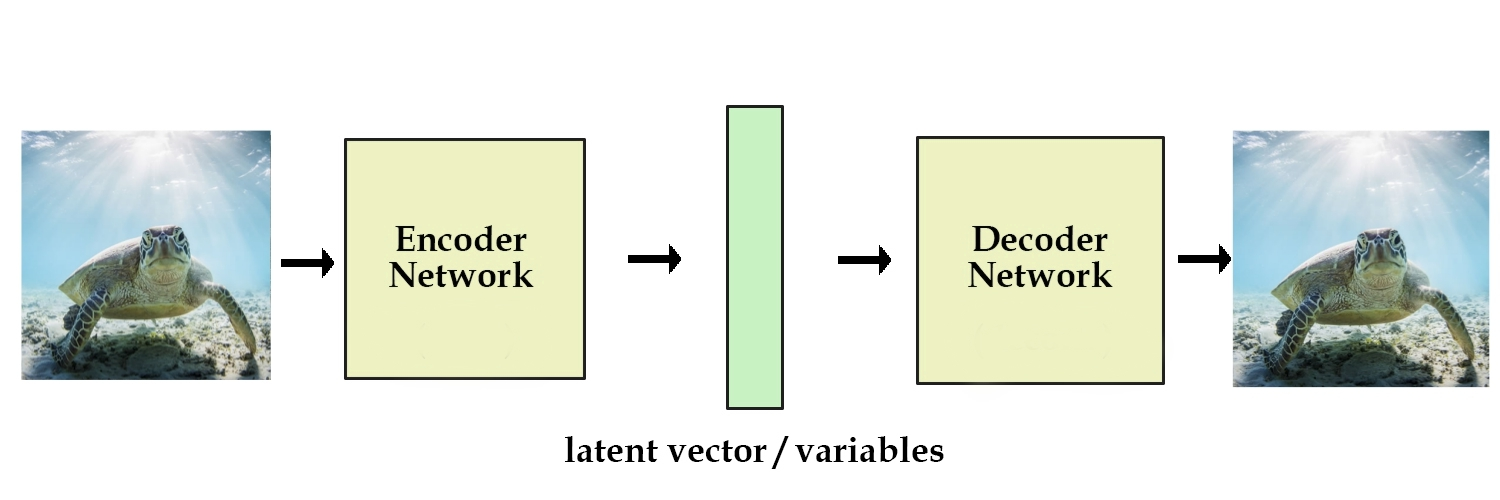

In [123]:
im('images/autoenc.jpg')

However in our case we're dealing with a different problem, as we're not looking for a model which can be used for memorizing or compressing images (which are usual applications of autoencoders), but to generate new unseen images. Here is where the main difference that characterizes variational autoencoders takes place. During training, an additional term is added to the loss function which imposes these latent vectors to *follow a certain distribution*, in this case a diagonal Gaussian distribution.

And how can this be useful? Well adding this constraint, allows us to very easily sample from this latent distribution generating random latent variables and thus generating new images.

The following schema shows in more detail the components of this architecture, where on the left a schema of a Conventional Variational Auto-Encoder can be seen, and on the right the DRAW network that is used here.

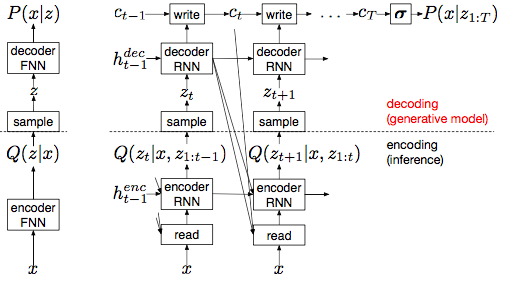

In [5]:
print ''
im('images/schema.png', width = 700)

The main difference that becomes the most obvious, is that in the DRAW arquitecture the encoder and decoder networks are Recurrent Neural Networks. Several advantages arise from providing an exchange of code samples between layers, the main one however is to allow the encoder tailor the codes it sends taking into account the decoder's behaviour so far, which enables one of the main features of the architecture, the progressive refinment of the images when training the model.

Also an advantage of this architecture is to allow the generation of the output data to be performed in several steps, instead of trying to finish the image in just one shot. By doing so the complexity of the data generation is drastically reduced, as we are splitting the problem in the temporal and spatial domain. This is, the network does not just progressively refine what will be the final distribution with which the image will be reconstructed over time, but it also focuses in small regions of the image at a time, and succesively reconstructs it entirely.

Let us see in more detail the different processes that take place in this architecture:

**1.1 Training:**

* During inference the input is read at every timestep, where the exact characteristics of the filter depend on the output of the previous RNNs, and the result is passed to the encoder RNN.

* The output of the encoder RNN is used to compute the approximate posterior $Q(z_t \mid h_t^{enc})$ over the latent variables at that time-step. Notice that as shown in the schema, this posterior is conditioned on the encoder's output, which depends on both $x$ and the history $z_{1:t-1}$ of previous latent samples, thus can be written as conditioned to both inputs. 
* At each time-step a sample $z_t$ from the prior $P(z_t)$ is passed to the recurrent decoder network, which then modifies part of the canvas matrix $c_t$ determined by the write operator. This final canvas matrix, once entirely build after all given time steps, is then used to compute the probability of the input data given the drawn latent vectors $P(x \mid z_{1:T})$.
    
    
**1.2 Stochastic data generation:**

Once the model has been trained, an image $\widetilde{x}$ can be generated by the DRAW network by iteratively picking latent samples $\tilde{z_t}$ from the prior $P(\tilde{z_t})$, and updating the canvas matrix $\widetilde c_t$ after running the decoder on each time step
    
Thus for this purpose we do not need the second half of the network, this is the read, encode, and sampleQ blocks, and just pass our own $z \sim \mathcal{N}\left (\mu, \Sigma \right)$ to the decoder. After $T$ repetitions of this process the generated image is a sample from $D(X \mid \widetilde c_T)$, this is $ x \sim D(X \mid \widetilde c_T)$

<h3> 2. Model implementation </h3>

Having gone through a general overview of the model, let us review the components of the model in more detail along with the code of an implementation of the model in TensorFlow.

The following are the main equations that take place and appear in the above block diagram of the model. The TensorFlow code has been implemented in a way such that it resembles the equations as much as possible in order to favour a clear understanding of the parts:

* $\widehat{x}_t=x-\sigma (c_t -1)$


* $r_t = read \left( x_t,\widehat{x}_t, h_{t-1}^{dec} \right)$


* $h_{t}^{enc} = RNN^{enc}\left (h_{t-1}^{enc} ,\left [ r_t, h_{t-1}^{dec} \right] \right)$


* $z_t \sim Q \left (Z_t \mid h_{t-1}^{enc}  \right)$


* $h_{t}^{dec} = RNN^{dec} \left( h_{t-1}^{dec},z_t \right)$


* $ c_t = c_{t-1} + write(h_{t}^{dec})$

Where $\widehat{x}_t$ is the error image, thus the difference between the image in the input of the encoder and the sigmoind function of the canvas matrix, and $\sigma$ denotes a logistic sigmoid function $ \sigma (x) = \frac{1}{1+exp(-x)}$.

Thus the tensors that must be defined and theyr weights are:

These main relations are defined bellow as:

In [ ]:
for t in range(T):
    # Previous state pf the canvas matrix, where if the current
    # time step is the first, it is initialized
    c_prev = tf.zeros((batch_size,img_size)) if t==0 else cs[t-1]
    x_hat=x-tf.sigmoid(c_prev) # Error image
    # Read operation defined further on
    r=read(x,x_hat,h_dec_prev) 
    # Encoder function 
    h_enc,enc_state=encode(enc_state,tf.concat(1,[r,h_dec_prev])) 
    # Sampling function 
    z,mus[t],logsigmas[t],sigmas[t]=sampleQ(h_enc) 
    # Decoder function 
    h_dec,dec_state=decode(dec_state,z) # eq 7
    # Update of the canvas matrix
    cs[t]=c_prev+write(h_dec)
    # Saves the previous h_dec output, input of the next read operator
    h_dec_prev=h_dec
DO_SHARE=True # from now on, share variables

<h4> 2.1 Selective attention model </h4>

The core idea behind spatial attention, is for the network to focus in smaller parts of the image instead of trying to reproduce it all in once, and this way notably reducing the complexity. Therefore at each time step, the input of the $RNN_{enc}$ as well as the $read$ operator receive the output of $RNN^{dec}_{t-1}$ making it possible to progressively refine the image and to also read from different locations of the image.
Then the output of the $RNN_{dec}$ is used to progressively update the canvas matrix, and build a more refined version of the input image at each time step.

In order to do so, an array of 2D Gaussian filters is applied to the inoput image, through which patches of it are obtained with smoothly varying location and zoom. Several constraints must also be added to the model in order to impose that these patches end up covering the whole input image.

The following illustration depicts the functionality of the attention window parameters, the grid centers $(g_X,g_Y)$ and the stride $\delta$. 

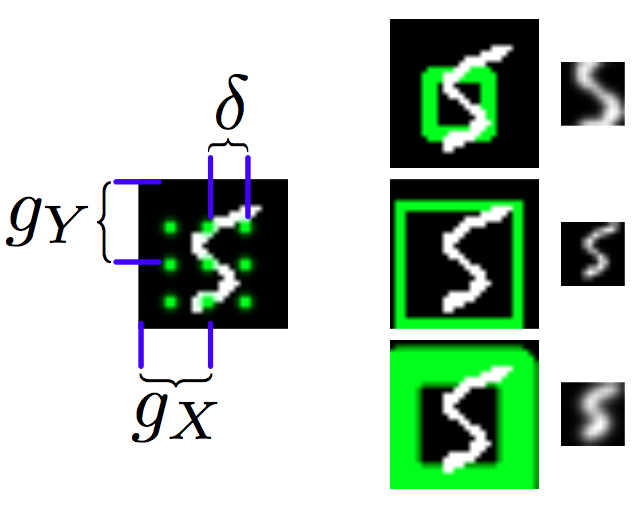

In [5]:
im("images/read.png", width = 350)

The grid centers determine the position at which the grid of Gaussian bumps is centered, and the stride the pixel separation between these.
Spacing these filters out means that we are downsampling the image, rather than just zooming really close.

The attention window parameters are obtained via a linear transformation of the decoder output, $h_{dec}$:

\begin{equation}
W\left (h^{dec} \right) = \left ( \tilde{g_X},\widetilde{g}_Y,log \sigma ^2, log \widetilde{ \delta}, log  \gamma \right)
\end{equation}



In order to do so we call the function "linear" defined bellow, which returns a linear transformation using the updated parameters of the network. The output vector is equally split into the several variables, denoted with a tilde ~, which are then used to update the attention window parameters, defined as:

* $g_{X} = \frac{A+1}{2}\left (\widetilde{g}_Y +1\right)$


* $g_{Y} = \frac{B+1}{2}\left (\widetilde{g}_X +1\right)$


* $\delta = \frac{max\left (A,B\right) -1}{N-1}\widetilde{\delta}$


In [6]:
def linear(x,output_dim):
    """
    affine transformation Wx+b
    assumes x.shape = (batch_size, num_features)
    """
    w=tf.get_variable("w", [x.get_shape()[1], output_dim])
    b=tf.get_variable("b", [output_dim], initializer=tf.constant_initializer(0.0))
    return tf.matmul(x,w)+b

Given that the encoder and decoder networks of the model are RNNs, we want to share the same set of parameters within the layers of each network recursively. This can be achieved in tensorflow using *tf.variable_scope*, which allows to share the same set of weights and biases within the different layers of the RNN, viewed as an time-unrolled network.

In [7]:
def attn_window(scope,h_dec,N):
    with tf.variable_scope(scope,reuse=DO_SHARE):
        params=linear(h_dec,5)
    gx_,gy_,log_sigma2,log_delta,log_gamma=tf.split(1,5,params)
    gx=(A+1)/2*(gx_+1)
    gy=(B+1)/2*(gy_+1)
    sigma2=tf.exp(log_sigma2)
    delta=(max(A,B)-1)/(N-1)*tf.exp(log_delta) # batch x N
    return filterbank(gx,gy,sigma2,delta,N)+(tf.exp(log_gamma),)

These parameters are used to determine the mean location of the filter at row $i$ and column $j$ in the patch as:

* $\mu_X^i = g_X + (i - N/2 - 0.5) \delta$


* $\mu_Y^j = g_Y + (j - N/2 - 0.5) \delta$

Also the isotropic variance of the Gaussian filters $\sigma^2$ and a scalar intensity $\gamma$ that multiplies the filter response are defined.

Given the attention parameters emitted by the decoder, the horizontal and vertical filterbank matrices $F_X$ and $F_Y$ are defined as follows:

* $F_X[i,a] = \frac{1}{Z_X} \mbox{exp} \left (-\frac{\left (a-\mu_X^i \right)^2}{2 \sigma^2} \right)$

* $F_Y[j,b] = \frac{1}{Z_Y} \mbox{exp} \left (-\frac{\left (b-\mu_Y^j \right)^2}{2 \sigma^2} \right)$

The extracted value for attention grid pixel $(i,j)$ is the convolution of the image with a 2D Gaussian bump whose $x$ and $y$ components are the respective $i$ and $j$ rows in $F_X$ and $F_Y$.

The following function returns the filterbank matrices from the attention window parameters:

In [8]:
def filterbank(gx, gy, sigma2,delta, N):
    grid_i = tf.reshape(tf.cast(tf.range(N), tf.float32), [1, -1])
    # Mean location of each Gaussian bump
    mu_x = gx + (grid_i - N / 2 - 0.5) * delta 
    mu_y = gy + (grid_i - N / 2 - 0.5) * delta 
    #(a,b) are points in the input image
    a = tf.reshape(tf.cast(tf.range(A), tf.float32), [1, 1, -1])
    b = tf.reshape(tf.cast(tf.range(B), tf.float32), [1, 1, -1])
    mu_x = tf.reshape(mu_x, [-1, N, 1])
    mu_y = tf.reshape(mu_y, [-1, N, 1])
    sigma2 = tf.reshape(sigma2, [-1, 1, 1])
    # Filterbank matrices
    Fx = tf.exp(-tf.square((a - mu_x) / (2*sigma2))) 
    Fy = tf.exp(-tf.square((b - mu_y) / (2*sigma2))) # batch x N x B
    # normalize, sum over A and B dims
    Fx=Fx/tf.maximum(tf.reduce_sum(Fx,2,keep_dims=True),eps)
    Fy=Fy/tf.maximum(tf.reduce_sum(Fy,2,keep_dims=True),eps)
    return Fx,Fy

<h4> 2.2 Reading and Writing With Attention </h4>

Given all the parameters of the filterbank, we define the read operation, which takes as arguments the input image $x$, the error image $\widehat{x}$, the parameters of the output of the decoder $h_{t-1}^{dec}$, denoted in the code as *h_dec_prev*; and returns the concatenation of two $N x N$ patches from the image and the error image, which are defined as:

$read(x,\widehat{x}_t,h_{t-1}^{dec}) = \gamma [F_Y x F_X^T, F_Y \widehat{x}F_X^T]$

Thus a patch from the image is obtained by directly multiplying both horizontal and vertical filterbanks, $F_Y x F_X^T$.

Notice that in the code, in oder to perform the multiplication, we must reshape the input image vector to its original dimentions, and perform both *tf.batch_matmul* operations. 

Afterwoods the obtained vector is reshaped again to an $NxN$ matrix due to the dimension of the filters, $NxA$ and $NxB$ respectively.

Bellow are defined both the $read$ operation functions both with and without attention. For the reading with no attention  we simply concatenate the image with the error image (difference between the image and the current reconstruction). 

In [9]:
def read_no_attn(x,x_hat,h_dec_prev):
    return tf.concat(1,[x,x_hat])

def read_attn(x,x_hat,h_dec_prev):
    Fx,Fy,gamma=attn_window("read",h_dec_prev,read_n)
    def filter_img(img,Fx,Fy,gamma,N):
        Fxt=tf.transpose(Fx,perm=[0,2,1])
        img=tf.reshape(img,[-1,B,A])
        patch=tf.batch_matmul(Fy,tf.batch_matmul(img,Fxt))
        patch=tf.reshape(patch,[-1,N*N])
        return patch*tf.reshape(gamma,[-1,1])
    x=filter_img(x,Fx,Fy,gamma,read_n) # batch x (read_n*read_n)
    x_hat=filter_img(x_hat,Fx,Fy,gamma,read_n)
    return tf.concat(1,[x,x_hat]) # concat along feature axis

For the write operation, we make use of the same functions previously reviewed $attn_window()$ and $filterbank()$, but with a different set of parameters, which we denote as $\widehat{\gamma}$, $\hat{F}_X$ and $\hat{F}_Y$ which in this case are extracted from $h_{t}^{dec}$.

$w_t = W(h_t^{dec})$

$write(h_t^{dec}) = \frac{1}{\widehat{\gamma}}\widehat{F}_Y^T w_t \widehat{F}_X$

Where in this case, the filters are applyied to an $NxN$ writing patch $w_t$.

In [10]:
def write_no_attn(h_dec):
    with tf.variable_scope("write",reuse=DO_SHARE):
        return linear(h_dec,img_size)

def write_attn(h_dec):
    with tf.variable_scope("writeW",reuse=DO_SHARE):
        w=linear(h_dec,write_size) # batch x (write_n*write_n)
    N=write_n
    w=tf.reshape(w,[batch_size,N,N])
    Fx,Fy,gamma=attn_window("write",h_dec,write_n)
    Fyt=tf.transpose(Fy,perm=[0,2,1])
    wr=tf.batch_matmul(Fyt,tf.batch_matmul(w,Fx))
    wr=tf.reshape(wr,[batch_size,B*A])
    #gamma=tf.tile(gamma,[1,B*A])
    return wr*tf.reshape(1.0/gamma,[-1,1])

<h4>2.2 Encoder</h4>

The following code is used to define the encoder RNN. *LSTMCell* is used to define a Long short-term memory unit (LSTM) recurrent network cell as an object, initialized with *enc_size* units and an input_size of *read_size+dec_size*, recall that the encoder network takes as input both the read operator's output and the output of the previous decoder $h_{t-1}^{dec}$.

*tf.variable_scope* is used again in order for all units of the RNN to share the same parameters.


In [11]:
def encode(state,input):
    """
    run LSTM
    state = previous encoder state
    input = cat(read,h_dec_prev)
    returns: (output, new_state)
    """
    with tf.variable_scope("encoder",reuse=DO_SHARE):
        return lstm_enc(input,state)

<h4> 2.4 Sampler </h4>

As mentioned earlier, the main motivation for using a diagonal Gaussian distribution for the latent space distribution is that we can then take advantage of the so-called reparametrization trick. The difficulty with these models arises when training the architecture end-to-end via gradient descent. How can we propagate the loss gradients through a function like *numpy.random.multivariate_normal()*?

Well to tackle this problem, what this method suggests is to simply rewrite $z \sim \mathcal{N}\left(\mu,\sigma \right)$ as $z = \mu + \mathcal{N}\left(0,1 \right) * \sigma$.
This way we the function can be derivated as $\partial z / \partial \mu = 1$ and $\partial z/ \partial \sigma = e$ where e = $\mathcal{N}\left(0,1 \right)$.

The following schema depicts the new architecture of the network, now differentiable taking advantage of the reparametrization trick:

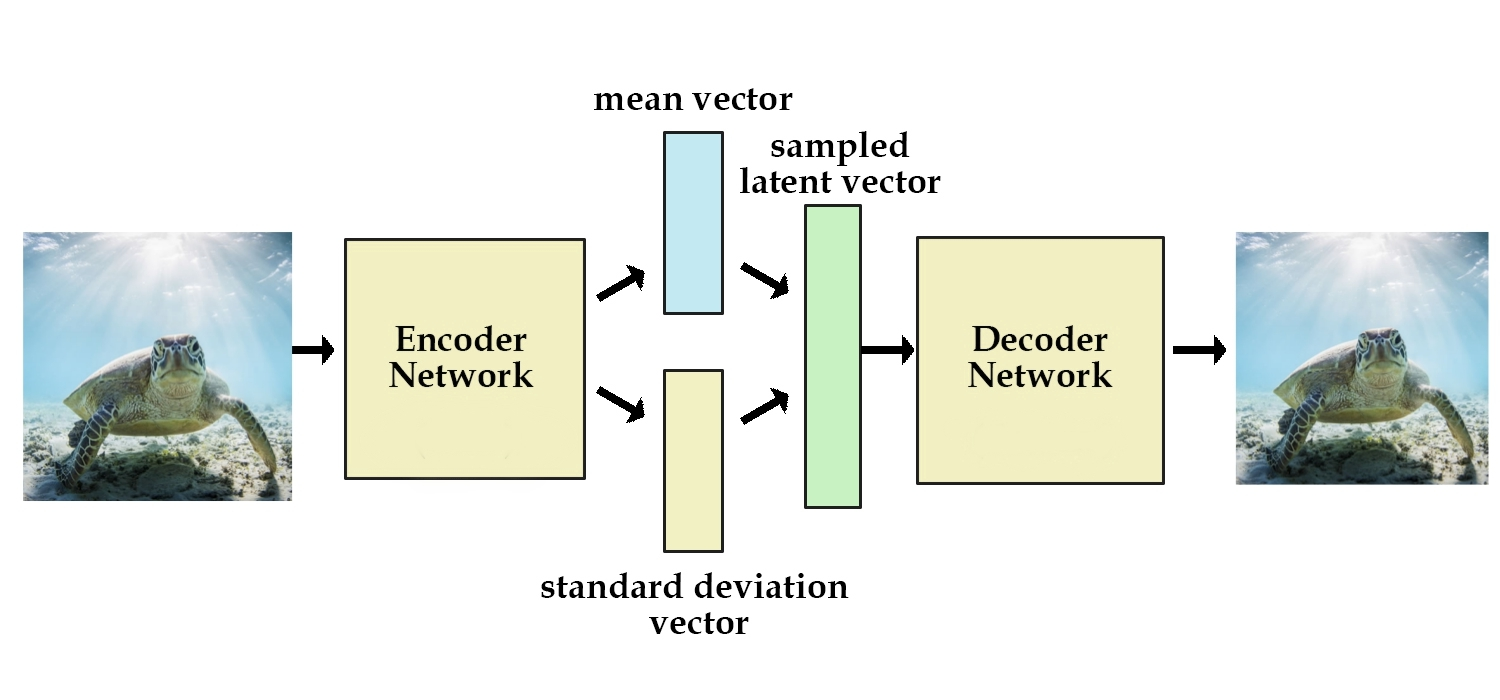

In [12]:
im('images/vae.jpg')

The code for the sampling is the following:

In [13]:
def sampleQ(h_enc):
    """
    Samples Zt ~ normrnd(mu,sigma) via reparameterization trick for normal dist
    mu is (batch,z_size)
    """
    with tf.variable_scope("mu",reuse=DO_SHARE):
        mu=linear(h_enc,z_size)
    with tf.variable_scope("sigma",reuse=DO_SHARE):
        logsigma=linear(h_enc,z_size)
        sigma=tf.exp(logsigma)
    return (mu + sigma*e, mu, logsigma, sigma)

In order to obtain the current updated $\mu$ and $\sigma$ during the training stage the a linear tranformation of $h_t^{enc}$ is taken for both the mean and variance, and return a sample $z = \mu + \mathcal{N}\left(0,1 \right) * \sigma$ from $Q$, where e is defined as: *e=tf.random_normal((batch_size,z_size), mean=0, stddev=1)*, thus ass adding a noise term from the sampler.

Having obtained $\left(\mu, \Sigma \right)$,  then we can create as many samples from the distribution $Q$ as we want using *numpy.random.multivariate_normal()*, and passing through these parameters.

<h4> 2.5 Decoder </h4>

For the decoding process, similarly to the encoder we call the defined *lstm_dec()* function and use *tf.variable_scope()* in order to share the variables within the different cells

In [14]:
def decode(state,input):
    with tf.variable_scope("decoder",reuse=DO_SHARE):
        return lstm_dec(input, state)

<h4> 2.6 Loss Function </h4>

The DRAW's model Loss Function is the expectation of the sum of the reconstruction Loss (how much the generated image resembles the input) and the latent loss (a measure of how bad our variational approximation is of the true latent distribution), which are themselves defined as:

* Reconstruction Loss: 

    $\mathcal{L}^x = -logD \left (x \mid c_T\right)$

Where $D \left (x \mid c_T\right)$ is the model our model for the input data given the final canvas matrix $c_t$ that has been recurrently constructed. The loss is hence defined as the negative log probability of $x$ under $D$, or in other words, the log-likelihood of the data. 
    
* Latent Loss:

    $ \mathcal{L}^z = \sum_{t=1}^T KL \left( Q\left( Z_t  \mid h_t^{enc} \right) \mid \mid P \left (Z_t\right)\right)$
    
Which consists on the summed Kullback-Leibler divergence of some latent prior $P(Z_t)$ from $Q\left (Z_t \mid h_t^{enc}\right)$, which is essentialy measuring how well the latent priors match the imposed latent space distribution, which in this case is chosen to be a diagonal Gaussian. The reason behind this is that the gradient of a function of the samples with respect to the distribution parameters in the case of Gaussian latents can be easily obtained using the so-called reparameterization trick, which makes it straightforward to back-propagate unbiased, low variance stochastic gradients of the loss function through the latent distribution.
    
The idea behind the reparametrization trick is that instead of the encoder generating a vector of real values, it will generate a vector of means and a vector of standard deviations. Thus when we're calculating the loss for the decoder network, we can just sample from the standard deviations and add the mean, and use that as our latent vector.
    
In this case a simple choice for the prior $P\left (Z_t\right)$ from which to draw samples from is a standart Gaussian $\mathcal{N}(0,1)$, we can rewrite the previous expression for the loss as:
    
$ \mathcal{L}^z = \frac{1}{2}\left(\sum_{t=1}^T \mu_t^2 + \sigma_t^2  - log \sigma_t^2 \right) - T/2$
    
Leaving us with the total loss $\mathcal{L}$ for the network, defined as the expectation of the sum of the reconstruction and latent losses:

$\mathcal{L} = \left \langle \mathcal{L}^x + \mathcal{L}^z \right \rangle _{z \sim Q}$

In [ ]:
def binary_crossentropy(t,o):
    return -(t*tf.log(o+eps) + (1.0-t)*tf.log(1.0-o+eps))

# reconstruction term appears to have been collapsed down to a single scalar value (rather than one per item in minibatch)
x_recons=tf.nn.sigmoid(cs[-1])

# Here the mean is taken over the sum of the binary cross entropy between the input image and
# the reconstructed image
Lx=tf.reduce_sum(binary_crossentropy(x,x_recons),1) 
Lx=tf.reduce_mean(Lx)

# The Latent loss is computed using the reparametrization trick from the Kullback-Leibler divergence
# Thus we sum over T sigma and mu terms sampled from the latent distribution and average over all minibatches
kl_terms=[0]*T
for t in range(T):
    mu2=tf.square(mus[t])
    sigma2=tf.square(sigmas[t])
    logsigma=logsigmas[t]
    kl_terms[t]=0.5*tf.reduce_sum(mu2+sigma2-2*logsigma,1)-T*.5 # each kl term is (1xminibatch)
KL=tf.add_n(kl_terms) # this is 1xminibatch, corresponding to summing kl_terms from 1:T
Lz=tf.reduce_mean(KL) # average over minibatches

# Final loss function, expectation of the sum of both terms, or equivalently sum of the expectations
cost=Lx+Lz

<h4> 2.7 Optimizer </h4>

The model has been optimized with an Adam Optimizer with a learning rate of 1e-3 and a $\beta = 0.5$.
The gradients are clipped before applying them with an optimizer, thus the tensors are normalized so that its L2-norm is less than or equal to $clip_norm$, set to be 5 in this case.

In [ ]:
optimizer=tf.train.AdamOptimizer(learning_rate, beta1=0.5)
grads=optimizer.compute_gradients(cost)
for i,(g,v) in enumerate(grads):
    if g is not None:
        grads[i]=(tf.clip_by_norm(g,5),v) 
train_op=optimizer.apply_gradients(grads)

<h3> 3. Training the Model </h3>

In this section the model is trained with the MNIST dataset (Salakhutdinov & Mur- ray, 2008).
Having trained the model, digits have been generated following the method specified in section 1.2, thus by picking random samples from the latent space and running the decoder.

The following code line generates some output files with the losses of the model and some example data:

In [49]:
!python draw.py --data_dir=output_attn --read_attn=True --write_attn=True

Extracting output/mnist/train-images-idx3-ubyte.gz
Extracting output/mnist/train-labels-idx1-ubyte.gz
Extracting output/mnist/t10k-images-idx3-ubyte.gz
Extracting output/mnist/t10k-labels-idx1-ubyte.gz
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/p

After about 10000 epochs we see that both the reconstruction and latent losses stabilize. Lets visualyze the evolution of the losses:

In [18]:
loss = np.load('output_attn/draw_data.npy')

In [19]:
Lx,Lz = loss[1:]

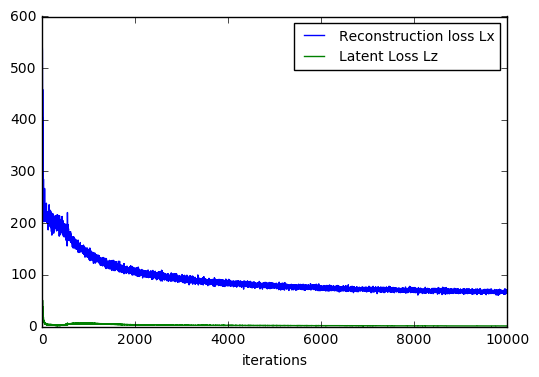

In [20]:
line1,=plt.plot(Lx)
line2,=plt.plot(Lz)
plt.legend([line1,line2],["Reconstruction loss Lx", "Latent Loss Lz"],prop={'size':10},loc=1)
plt.xlabel('iterations')
plt.show()

<h4> 3.1 With attention </h4>

Here's an example of MNIST being generated after training, in this case with attention :

In [11]:
!python ../plot_data.py generated_attn/attn output_attn/draw_data.npy

../plot_data.py:44: RuntimeWarning: overflow encountered in exp
  X=1.0/(1.0+np.exp(-C)) # x_recons=sigmoid(canvas)
generated_attn/attn_0.png
generated_attn/attn_1.png
generated_attn/attn_2.png
generated_attn/attn_3.png
generated_attn/attn_4.png
generated_attn/attn_5.png
generated_attn/attn_6.png
generated_attn/attn_7.png
generated_attn/attn_8.png
generated_attn/attn_9.png


In [12]:
images = []
for i in range(1,10):
    images.append(mpimg.imread('generated_attn/attn_{}.png'.format(i)))
imageio.mimsave('animation_attn.gif', images)

It is interesting to see how as the following animation shows, how the digits are traced much like a person with a pen, given the attention in the writting operation of the image

In [13]:
display(im(url='animation_attn.gif'))

<h4> 3.1 Without attention </h4>

Lets have a look at the same results when the model is trained without attention:

In [48]:
!python ../draw.py --data_dir=output_no_attn --read_attn=False --write_attn=False

Extracting output_no_attn/mnist/train-images-idx3-ubyte.gz
Extracting output_no_attn/mnist/train-labels-idx1-ubyte.gz
Extracting output_no_attn/mnist/t10k-images-idx3-ubyte.gz
Extracting output_no_attn/mnist/t10k-labels-idx1-ubyte.gz
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU c

In [8]:
!python plot_data.py generated_no_attn/no_attn output_no_attn/draw_data.npy

generated_no_attn/no_attn_0.png
generated_no_attn/no_attn_1.png
generated_no_attn/no_attn_2.png
generated_no_attn/no_attn_3.png
generated_no_attn/no_attn_4.png
generated_no_attn/no_attn_5.png
generated_no_attn/no_attn_6.png
generated_no_attn/no_attn_7.png
generated_no_attn/no_attn_8.png
generated_no_attn/no_attn_9.png


In [9]:
images = []
for i in range(1,10):
    images.append(mpimg.imread('generated_no_attn/no_attn_{}.png'.format(i)))
imageio.mimsave('animation_no_attn.gif', images)

It is interesting to see that in this case as expected, the resulting canvas for the different time steps is increasingly sharpening in a global manner. In this case we only see an image that goes from blurry to sharpen, given that there is a progressive refinement through time but without spatial attention: 

In [10]:
display(im(url='animation_no_attn.gif'))